# Chatbot Project

In [36]:
# Requirements
#import sys

#!{sys.executable} -m pip install chatintents
#!{sys.executable} -m pip install hyperopt
#!{sys.executable} -m pip install keras_tuner
#!{sys.executable} -m pip install matplotlib
#!{sys.executable} -m pip install nltk
#!{sys.executable} -m pip install numpy
#!{sys.executable} -m pip install pandas
#!{sys.executable} -m pip install seaborn
#!{sys.executable} -m pip install sklearn
#!{sys.executable} -m pip install spacy
#!{sys.executable} -m pip install tensorflow-cpu
#!{sys.executable} -m pip install tensorflow_hub
#!{sys.executable} -m pip install tqdm
#!{sys.executable} -m pip install numba
#!{sys.executable} -m spacy download en_core_web_sm

In [55]:
import chatintents
import datetime
import json
import keras_tuner
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import nltk
import pickle
import random
import re
import sklearn
import spacy
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from chatintents import ChatIntents
from hyperopt import hp
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tqdm import tqdm

DATA_DIR = 'input/chat_logs'
LABEL_FILE = 'input/unsupervised_labeled_data.csv'
INTENT_FILE = 'input/intents.json'
MODEL_PATH = 'outputs/saved_model_keras'
MODEL_HISTORY = 'outputs/HistoryDict'

%matplotlib inline

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
embedder = hub.load(module_url)
print(f"module {module_url} loaded")

pd.set_option("display.max_rows", 60)
pd.set_option("display.max_columns", 50)
pd.set_option("max_colwidth", 40)

nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


## Data preprocessing

In [2]:
class Utt:
    '''Class for processing and normalizing raw text.'''

    def __init__(self, text, query=False):
        '''Args:
            text (str): Raw text from chat transcript.
            query (bool, optional): If True, the output of the class will be
            retricted to only the text.
        '''

        self.text = text
        
        # dictionary of shorthand tokens that require expanding
        self.norm_dict = {
           "btw":"by the way",
           "aint":"is not",
           "arent":"are not",
           "cant":"cannot",
           "cause":"because",
           "couldve":"could have",
           "couldnt":"could not",
           "didnt":"did not",
           "doesnt":"does not",
           "dont":"do not",
           "hadnt":"had not",
           "hasnt":"has not",
           "havent":"have not",
           "hed":"he would",
           "hell":"he will",
           "hes":"he is",
           "howd":"how did",
           "howdy":"how do you",
           "howll":"how will",
           "hows":"how is",
           "Id":"I would",
           "Idve":"I would have",
           "Ill":"I will",
           "Illve":"I will have",
           "Im":"I am",
           "Ive":"I have",
           "id":"i would",
           "idve":"i would have",
           "ill":"i will",
           "illve":"i will have",
           "im":"i am",
           "ive":"i have",
           "isnt":"is not",
           "itd":"it would",
           "itdve":"it would have",
           "itll":"it will",
           "itllve":"it will have",
           "its":"it is",
           "lets":"let us",
           "maam":"madam",
           "maynt":"may not",
           "mightve":"might have",
           "mightnt":"might not",
           "mightntve":"might not have",
           "mustve":"must have",
           "mustnt":"must not",
           "mustntve":"must not have",
           "neednt":"need not",
           "needntve":"need not have",
           "ok": "okay",
           "oclock":"of the clock",
           "oughtnt":"ought not",
           "oughtntve":"ought not have",
           "shant":"shall not",
           "shant":"shall not",
           "shantve":"shall not have",
           "shed":"she would",
           "shedve":"she would have",
           "shell":"she will",
           "shellve":"she will have",
           "shes":"she is",
           "shouldve":"should have",
           "shouldnt":"should not",
           "shouldntve":"should not have",
           "sove":"so have",
           "sos":"so as",
           "thiss":"this is",
           "thatd":"that would",
           "thatdve":"that would have",
           "thats":"that is",
           "thered":"there would",
           "theredve":"there would have",
           "theres":"there is",
           "heres":"here is",
           "theyd":"they would",
           "theydve":"they would have",
           "theyll":"they will",
           "theyllve":"they will have",
           "theyre":"they are",
           "theyve":"they have",
           "tove":"to have",
           "wasnt":"was not",
           "wed":"we would",
           "wedve":"we would have",
           "well":"we will",
           "wellve":"we will have",
           "were":"we are",
           "weve":"we have",
           "werent":"were not",
           "whatll":"what will",
           "whatllve":"what will have",
           "whatre":"what are",
           "whats":"what is",
           "whatve":"what have",
           "whens":"when is",
           "whenve":"when have",
           "whered":"where did",
           "wheres":"where is",
           "whereve":"where have",
           "wholl":"who will",
           "whollve":"who will have",
           "whos":"who is",
           "whove":"who have",
           "whys":"why is",
           "whyve":"why have",
           "willve":"will have",
           "wont":"will not",
           "wontve":"will not have",
           "wouldve":"would have",
           "wouldnt":"would not",
           "wouldntve":"would not have",
           "yall":"you all",
           "yalld":"you all would",
           "yalldve":"you all would have",
           "yallre":"you all are",
           "yallve":"you all have",
           "youd":"you would",
           "youdve":"you would have"
        }

        self.query = query
        
        # process text
        if not self.query:
            self.participant, self.utt_preprocess, self.utt = self._preprocess_text()
        else:
            self.utt_preprocess = self.text.lstrip().lower()

        # clean utt
        self.utt_clean = self._clean_utt()

    def _preprocess_text(self):
        '''Takes transcript line, removes dates and returns participant number
        and lowered text.'''

        text = re.sub(r'\(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\) ', '', self.text)
        try:
            participant, text = text.split(':', 1)
            if text:
                if participant.startswith('Visitor'):
                    participant = 1
                else:
                    participant = 2
                return participant, text.lstrip().lower(), text
        except ValueError:
            pass

    def _clean_utt(self):
        '''Cleans text of urls and everything by alpha characters
        and single-wide whitespace'''

        utt_clean = re.sub(r'http.*\b', '', self.utt_preprocess)
        utt_clean = utt_clean.replace('-', ' ')
        utt_clean = re.sub(r"[^a-z ]", '', utt_clean)
        self.utt_clean = re.sub(r' {2,}', ' ', utt_clean)

        return self.utt_clean

    def _norm_utt(self):
        '''Replaces contracted tokens with expanded forms in text'''

        for token, repl in self.norm_dict.items():
            utt_norm = self.utt_clean.replace(token, repl)

        return utt_norm

    def _limit_utt_length(self, utt):
        '''Checks if utterance is within is certain length range.
        Returns utt if in range or returns None'''

        if len(utt) > 50:
            utt = None
        if len(utt) < 1:
            utt = None
        return utt

    def parse_utt(self):
        '''Process clean utt to: Normalize contractions, lemmatize tokens,
        check utterance within lenth range. If self.query is True returns utterance
        else returns participant numner, original utt, and preprocessed utt.'''

        if self.utt_clean:
            utt_norm = self._norm_utt()
            doc = nlp(utt_norm)
            list_lemma = [token.lemma_ for token in doc if len(token) > 1]
            utt = self._limit_utt_length(list_lemma)
            if utt:
                utt = ' '.join(utt)
                if not self.query:
                    return self.participant, self.utt, utt
                return utt

In [6]:
def parse_files(directory):
    '''Takes a directory containing raw chat logs as input and returns data frame of
    preprocessed text with speaker number.'''

    data = []
    for filename in os.listdir(directory):
        if filename.endswith(".text"):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r', encoding="utf-8") as f:
                for line in f:
                    line = line.strip()
                    if line.startswith(r'('):
                        try:
                            utt_object = Utt(line, query=False)
                            participant, utt, parsed_utt = utt_object.parse_utt()
                            if parsed_utt:
                                data.append([participant, utt, parsed_utt])
                        except TypeError:
                            pass

    if data:
        df = pd.DataFrame(data, columns=['participant', 'original_text', 'text'])
        df.participant = df.participant.astype('category')
        return df

In [7]:
data = parse_files(DATA_DIR)

In [8]:
data

,participant,original_text,text
0,2,"Hi, please let me know how I can he...",hi please let I know how can help yo...
1,2,View a list of 230+ end-to-end Mach...,view list of end to end machine lear...
2,2,Solution code + videos + tech suppo...,solution code video tech support moc...
3,1,Hi,hi
4,2,Hello,hello
...,...,...,...
9748,2,thank you,thank you
9749,1,Wish you a good day,wish you good day
9750,1,take care,take care
9751,2,you too,you too


## Exploratory Data Analysis

In [43]:
class ExploreData:
    '''Class for exploring features of data in dataframe.'''

    def __init__(self, data):
        '''Args:
            data (:obj:`dataframe`): Tabularised chat transcript data.
        '''

        # concatenated text data
        self.text = ' '.join(list(data['text'].values))

        # list of utterances
        self.sents = data["text"].tolist()
        
        # list of all tokens
        self.tokens = self.text.split()

    def get_token_frequency_dist(self):
        '''Takes list of tokens and prints frequency distribution of tokens.'''

        print(FreqDist(self.tokens))

    def get_top_n_tokens(self, n: int):
        '''Takens integer as n and returns top n high frequency tokens.'''

        return FreqDist(self.tokens).most_common(n)

    def plot_dist_curve(self):
        '''Plots frequency (zipf) curve of tokens.'''

        fig, ax = plt.subplots(figsize=(12,8))
        FreqDist(self.tokens).plot(40, cumulative=False)
        plt.show()

    def get_token_length_visualisations(self):
        '''Plot histogram of token lengths.'''

        lengths = [len(i) for i in self.tokens]
        plt.figure(figsize=(13,6))
        plt.hist(lengths, bins = 40)
        plt.title("Length of tokens in text")
        plt.show()

    def get_sent_length_visuals(self):
        '''Plot histogram of sentence lengths.'''

        lengths = [len(i) for i in self.sents]
        plt.figure(figsize=(13,6))
        plt.hist(lengths, bins = 40)
        plt.title("Length of sentences")
        plt.show()

In [44]:
eda = ExploreData(data)

In [45]:
eda.get_token_frequency_dist()

<FreqDist with 2492 samples and 60239 outcomes>


In [47]:
eda.get_top_n_tokens(20)

[('you', 2515),
 ('be', 1991),
 ('the', 1782),
 ('to', 1492),
 ('can', 1127),
 ('have', 1122),
 ('project', 1087),
 ('do', 1058),
 ('for', 1030),
 ('and', 931),
 ('we', 884),
 ('will', 819),
 ('ok', 771),
 ('of', 743),
 ('your', 611),
 ('it', 609),
 ('I', 595),
 ('please', 573),
 ('month', 559),
 ('end', 551)]

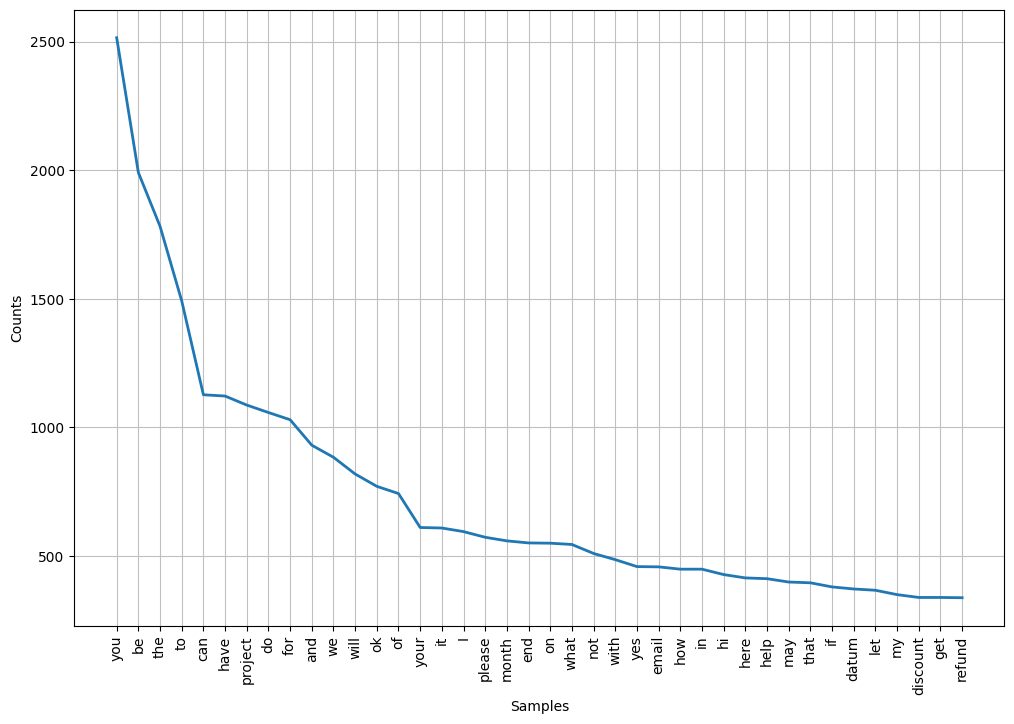

In [48]:
eda.plot_dist_curve()

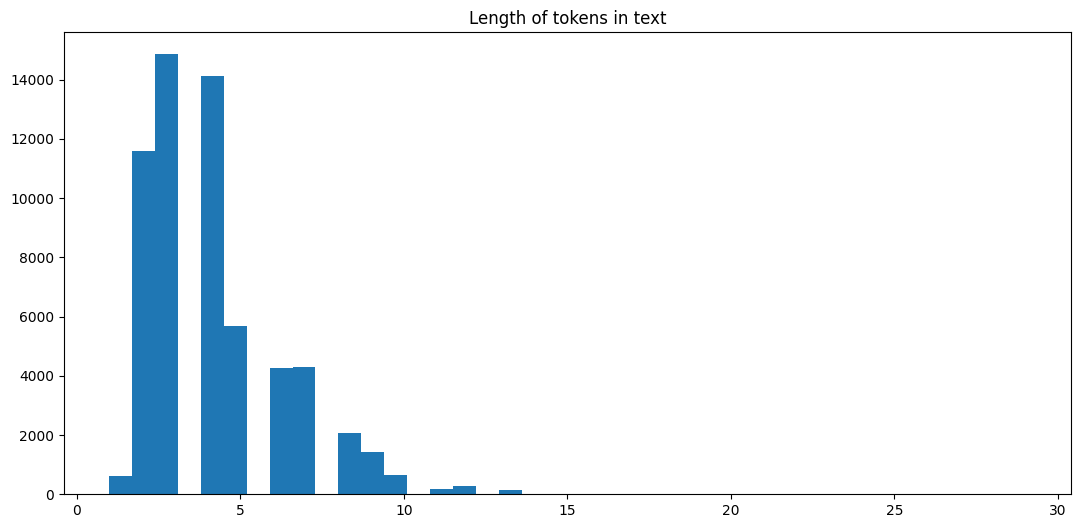

In [50]:
eda.get_token_length_visualisations()

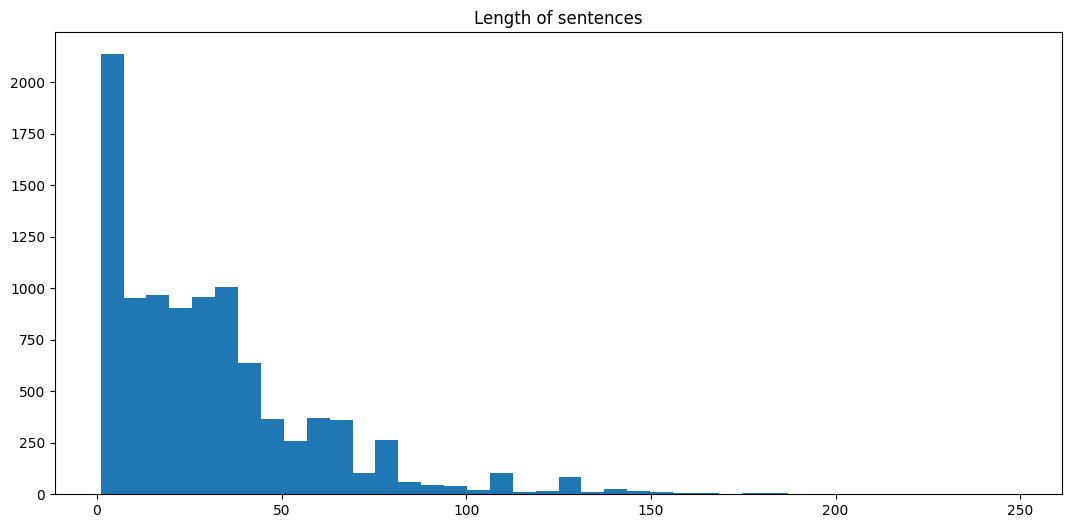

In [12]:
eda.get_sent_length_visuals()

## Cluster Intent Labels

In [9]:
class ClusterIntents:
    '''Class for clustering utterances and generating labels for clusters.'''

    def __init__(self, data, label_file, sorted_labels=False):
        '''Args:
            data (:obj:`dataframe`): Tabularised chat transcript data.
            label_file (str): Variable for path to save output file with labelled utterances.
            module_url (str): Variable for url to pretrained Universal
            Sentence Encoder model.
            sorted_labels (bool, optional): Option to sort output file by labels instead of
            by original chat order.
        '''

        self.data = data
        self.label_file = label_file

        # list of utterances
        all_intents = self.data['text'].tolist()

        # numpy array of document embeddings
        embeddings = embedder(all_intents)
        
        # convert embeddings array to sentence embeddings using USE
        model = ChatIntents(embeddings, 'use')

        # hyperparameter search configuration
        hspace = {
            "n_neighbors": hp.choice('n_neighbors', range(3,16)),
            "n_components": hp.choice('n_components', range(3,16)),
            "min_cluster_size": hp.choice('min_cluster_size', range(23,38)),
            "min_samples": None,
            "random_state": 42
        }

        # label number upper and lower bounds
        label_lower = 30
        label_upper = 100
        
        # maximum number of search runs
        max_evals = 25

        # run bayesian hyperparameter search
        model.bayesian_search(space=hspace,
                              label_lower=label_lower,
                              label_upper=label_upper,
                              max_evals=max_evals)

        # print the best model parameters found search
        model.best_params
        
        # hyperparameter optimized instance attribute
        self.model_final = model
        
        # generate summary dataframe and labeled utts dataframe
        self.df_summary, self.labeled_utts = self.model_final.apply_and_summarize_labels(data[['text']])
        
        # original data with appended labels data
        self.labeled_data = self._get_labeled_data()

        if sorted_labels:
            self.labeled_data = self.get_sorted_labels()
        
        # output csv file containing extended data input
        self._get_data_csv()
        print(f'Labelled utterances successfuly written to {label_file}')

    def get_model_best_params(self):
        '''Prints the final best parameters derived through search.'''

        return self.model_final.trials.best_trial

    def get_cluster_plot(self):
        '''Plot the clusters found from clustering.'''

        return self.model_final.plot_best_clusters()

    def get_labels_summary(self, n: int):
        '''Print n slice of labels summary.'''

        return self.df_summary.head(n)

    def get_labeled_utts(self, n: int):
        '''Print n slice of labelled utterances.'''

        return self.labeled_utts.head(n)

    def _get_labeled_data(self):
        '''Takes original data input adds label column and then removes duplicate
        utterances that have the same label.'''

        data_copy = self.data.copy()
        data_copy['label'] = self.labeled_utts['label']
        data_copy_dedup = data_copy.drop_duplicates(subset=['original_text', 'text', 'label'], keep='first')
        return data_copy_dedup

    def _get_sorted_labels(self):
        '''Sort extended data table by label.'''

        return self.labeled_data.sort_values(by=['label'])

    def _get_data_csv(self):
        '''Exports extended data to csv file.'''

        return self.labeled_data.to_csv(self.label_file)

In [10]:
cluster = ClusterIntents(data, LABEL_FILE)

100%|███████████████████████| 25/25 [13:15<00:00, 31.83s/trial, best loss: 0.24187429508869066]
best:
{'min_cluster_size': 24, 'min_samples': None, 'n_components': 9, 'n_neighbors': 11, 'random_state': 42}
label count: 80
Labelled utterances successfuly written to input/unsupervised_labeled_data.csv


In [15]:
cluster.get_model_best_params()

{'state': 2,
 'tid': 11,
 'spec': None,
 'result': {'loss': 0.21090946375474212, 'label_count': 97, 'status': 'ok'},
 'misc': {'tid': 11,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'min_cluster_size': [11],
   'n_components': [11],
   'n_neighbors': [11]},
  'vals': {'min_cluster_size': [3], 'n_components': [6], 'n_neighbors': [0]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2022, 9, 15, 2, 2, 24, 496000),
 'refresh_time': datetime.datetime(2022, 9, 15, 2, 2, 37, 687000)}

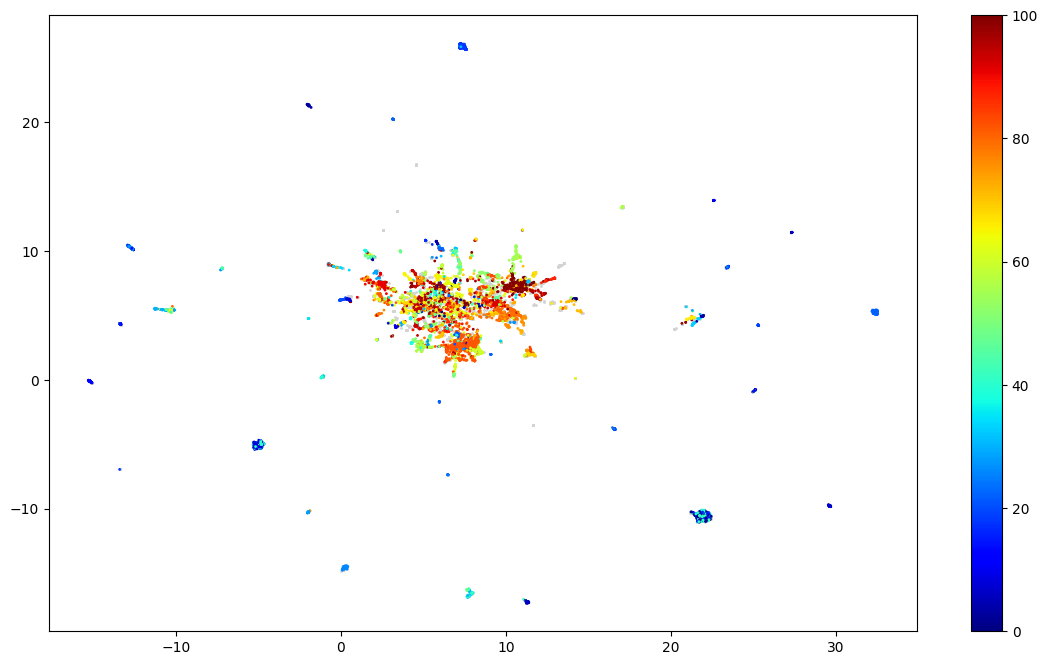

In [16]:
cluster.get_cluster_plot()

In [17]:
cluster.get_labels_summary(20)

,label_use,count,label
0,-1,2194,ok_guarantee_month_interview
83,82,579,want_project_data
19,18,223,hi
23,22,218,learn_project_end_view
42,41,210,yes
57,56,173,like_demo_project
9,8,167,yes_invitation_student_anm
67,66,160,let_time_conveninet
80,79,158,help_discount_student
101,100,154,want_subscription_month_plan


In [18]:
cluster.get_labeled_utts(20)

,text,label_use,label
0,hi please let I know how can help yo...,27,let_collaboration_today_demo
1,view list of end to end machine lear...,22,learn_project_end_view
2,solution code video tech support moc...,-1,ok_guarantee_month_interview
3,hi,18,hi
4,hello,3,hello_guy_number
5,datum course duration,82,want_project_data
6,data secience course duration,82,want_project_data
7,what do you do currently what kind o...,6,know_kind_technology_country
8,govt department as programmer,82,want_project_data
9,ours be project base learn platform,70,walk_insight_platform_project


## Prepare data

In [11]:
with open(INTENT_FILE, 'r') as f:
    intent_data = json.load(f)

intents = sorted(list(intent_data.keys()))

In [12]:
intent_data

{'interview_resume': {'1': ['also can you help me with resume',
   'Do you have one to one resume prep',
   'also, can i get resume guidance as well?',
   'Any interview tips and guidance for me to crack?',
   'Do i get resume tips and mock interviews aswell?',
   'and what about the interviews training',
   'how you guys choose projects to crack the interview',
   'also let me know how you can help me with interview prep'],
  '2': ['we provide resume preparation and mock interviews']},
 'live_session_mentoring': {'1': ['do u provide live session also',
   'do you ny technical guidence or session in this',
   'no live classes?',
   'will i have live mentor',
   '1 - 1 live mentoring too?',
   'or there will be any mentoring',
   'Will I get mentor who will guide me from scratch how to upload data, clean data and so on..'],
  '2': ['you will get help in customised projects in 1-1 sessions',
   'you get unlimitted sessions with experts to clariffy your queries',
   'You take help of our 

In [13]:
class PrepareData:
    '''Class for preparing data for training.'''

    def __init__(self, json_data, intents):
        '''Args:
            json_data (str): Variable for path to json intents file.
            intents (:obj: `list`): List of intents.
        '''

        # load intents data into dataframe
        self.df = pd.DataFrame.from_dict(json_data)
        
        self.intents = intents

        self.df_reformat = self._reformat_intents_df()
        self.df_preprocessed = self._preprocess_utts()
        df_one_hot_labels = self._encode_labels()
        self.df_concat = pd.concat([self.df_preprocessed, df_one_hot_labels], axis=1)
        self.df_train, self.df_val, self.df_test = self._get_train_val_test()
        self.train_x, self.val_x, self.test_x, self.train_y, self.val_y, self.test_y = self._get_input_output()

    def _reformat_intents_df(self):
        '''Takes data frame, removes response column
        and expands query list to individual rows with matching intent.'''

        df_T =  self.df.T.reset_index()
        df_T.columns = ["intent", "query", "response"]
        df_drop_response = df_T.drop(columns="response")
        df_drop_response.intent = df_drop_response.intent.astype('category')
        df_explode = df_drop_response.explode('query')
        return df_explode

    def _preprocess_utts(self):
        '''Passes utterances through preprocessing
        and deduplicates utterances of the same intent label.'''

        self.df_reformat['query_preprocessed'] = self.df_reformat.apply(lambda row: Utt(row['query'], query=True).parse_utt(), axis = 1)
        df_filter = self.df_reformat.dropna()
        df_dedup = df_filter.drop_duplicates(subset=['intent', 'query'], keep='first')
        return df_dedup

    def _encode_labels(self):
        '''One hot encodes labels.'''

        df_one_hot_intents = pd.get_dummies(self.df_preprocessed.intent)
        return df_one_hot_intents

    def _get_train_val_test(self):
        '''Split randomized data into train/eval/test with 80:10:10 ratio.'''

        df_train, df_val, df_test = np.split(self.df_concat.sample(frac=1, random_state=42),
                                             [int(.8*len(self.df_concat)), int(.9*len(self.df_concat))])
        return df_train, df_val, df_test

    def _get_input_output(self):
        '''Converts input and output taxt and labels to numpy arrays.'''

        train_queries_list = self.df_train['query_preprocessed'].tolist()
        val_queries_list = self.df_val['query_preprocessed'].tolist()
        test_queries_list = self.df_test['query_preprocessed'].tolist()

        train_x = np.array(train_queries_list, dtype=object)[:, np.newaxis]
        val_x = np.array(val_queries_list, dtype=object)[:, np.newaxis]
        test_x = np.array(test_queries_list, dtype=object)[:, np.newaxis]

        df_train_y = self.df_train.iloc[:,3:]
        df_val_y = self.df_val.iloc[:,3:]
        df_test_y = self.df_test.iloc[:,3:]

        train_y = df_train_y.to_numpy()
        val_y = df_val_y.to_numpy()
        test_y = df_test_y.to_numpy()

        return train_x, val_x, test_x, train_y, val_y, test_y

In [14]:
prep = PrepareData(intent_data, intents)

In [15]:
prep.df_preprocessed

,intent,query,query_preprocessed
0,interview_resume,also can you help me with resume,also can you help I with resume
0,interview_resume,Do you have one to one resume prep,do you have one to one resume prep
0,interview_resume,"also, can i get resume guidance as w...",also can get resume guidance as well
0,interview_resume,Any interview tips and guidance for ...,any interview tip and guidance for I...
0,interview_resume,Do i get resume tips and mock interv...,do get resume tip and mock interview...
...,...,...,...
39,i_get_back,right now cant make teh payment,right now can not make teh payment
39,i_get_back,I will think about it. Thanks for yo...,will think about it thank for your t...
39,i_get_back,Hey I need some time to think,hey need some time to think
39,i_get_back,okay ..will contact you tomorrow,okay will contact you tomorrow


In [16]:
train_x, val_x, test_x, train_y, val_y, test_y = prep.train_x, prep.val_x, prep.test_x, prep.train_y, prep.val_y, prep.test_y

## Train model

In [23]:
class ModelTrain:
    '''Class tuning model and then training.'''

    def __init__(self, train_x, val_x, train_y, val_y, module_url):
        '''Args:
            train_x (array): Numpy array of training utterances.
            val_x (array): Numpy array of validation utterances.
            train_y (array): Numpy array of one hot encoded training labels.
            val_y (array): Numpy array of one hot encoded validation labels.
            module_url (str): Variable for url to pretrained Universal
            Sentence Encoder model.
        '''

        self.train_x, self.val_x, self.train_y, self.val_y = train_x, val_x, train_y, val_y

        # initialise input layer with pretrained USE weights
        self.embed = hub.KerasLayer(module_url, input_shape=[], dtype=tf.string, trainable=True)

        # hyperparamter tuning
        self.tuner = keras_tuner.BayesianOptimization(
            self._build_model,
            objective="val_loss",
            max_trials=25,
            overwrite=True,
            directory="outputs/hp_dir",
            project_name="tune_hypermodel"
        )

        # Early stopping
        self.early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        self._tune_parameters()

        # print best hyperparameters
        best_hps = self.tuner.get_best_hyperparameters(num_trials=1)[0]

        # configure model with best hyperparameters
        self.model = self.tuner.hypermodel.build(best_hps)

        self.best_epoch = self._get_best_epoch()

        # monitor training on tensorboard
        log_dir = "log/intent_recognition/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
        self.tensorboard_cb = keras.callbacks.TensorBoard(log_dir=log_dir)

        self._train()

        print('Training complete!')

        # save model
        self.model.save("../outputs/saved_model_keras")

    def _tune_parameters(self):
        '''Performs hyperparameter tuning.'''

        self.tuner.search(
            self.train_x,
            self.train_y,
            epochs=10,
            validation_data=(self.val_x, self.val_y),
            callbacks=[self.early_stopping]
        )

    def _get_best_epoch(self):
        '''Gets best epoch number for training.'''

        history = self.model.fit(
            self.train_x,
            self.train_y,
            epochs=50,
            validation_data=(self.val_x, self.val_y),
            callbacks=[self.early_stopping],
            workers=4,
            use_multiprocessing=True
        )

        val_loss_per_epoch = history.history['val_loss']
        best_epoch = val_loss_per_epoch.index(max(val_loss_per_epoch)) + 1
        print(f'Best epoch: {best_epoch}')

        return best_epoch

    def _build_model(self, hp):
        '''Compile model'''

        model = tf.keras.models.Sequential()
        model.add(self.embed)
        for i in range(hp.Int("num_layers", 1, 3)):
            model.add(
                layers.Dense(
                    units=hp.Int("units", min_value=128, max_value=512, step=128),
                    activation=hp.Choice("activation", ["relu", "tanh", "sigmoid"])
                )
            )
            model.add(
                layers.Dropout(
                    hp.Choice('dropout_rate', values=[0.1, 0.3, 0.5])
                )
            )
        model.add(layers.Dense(41, activation="softmax"))
        learning_rate = hp.Choice('lr', values=[1e-2, 1e-3, 1e-4])
        model.compile(
            loss='categorical_crossentropy',
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            metrics=['categorical_accuracy']
        )
        return model

    def get_search_summary(self):
        '''Get summary of hyperparameter search space.'''

        return self.tuner.search_space_summary()

    def get_results_summary(self):
        '''Get summary of tuning results.'''

        return self.tuner.results_summary()

    def get_model_summary(self):
        '''Get summary of final model.'''

        return self.model.summary()

    def get_model_diagram(self):
        '''Get diagram of model architecture.'''

        return keras.utils.plot_model(self.model, "Model_Diagram.png", show_shapes=True)

    def _train(self):
        '''Train the model.'''

        # Train the model one final time while saving the best model.
        history = self.model.fit(
            self.train_x,
            self.train_y,
            epochs=self.best_epoch,
            validation_data=(self.val_x, self.val_y),
            callbacks=[self.early_stopping, self.tensorboard_cb],
            workers=4,
            use_multiprocessing=True
        )

        with open('../outputs/HistoryDict', 'wb') as f:
            pickle.dump(history.history, f)

In [15]:
# train = ModelTrain()

In [17]:
# train.get_search_summary()

In [18]:
# train.get_results_summary()

In [19]:
# train.get_model_summary()

In [20]:
# train.get_model_diagram()

## Evaluate model

In [83]:
class Eval:
    '''Class for model evaluation.'''

    def __init__(self, model, td, intents, test_x, test_y):
        '''Args:
            model (str): Variable name for model path.
            td (:obj:, `dataframe`): Dataframe from prapare data object.
            intents (:obj:`list`): Ordered list of intent labels.
            test_x (array): Numpy array of test utterances.
            test_y (array): Numpy array of one hot encoded test labels.
        '''

        self.test_x = test_x
        self.test_y = test_y
        
        self.intents = intents

        # get column containing labels of test data
        self.df_test = td.df_test.iloc[:, 0:1]
        
        # get label predictions of test inputs
        predicts = model.predict(self.test_x, batch_size=32)

        # Get predicted labels that are above 0.5 probability
        self.predict_logits = predicts.argmax(axis=1)        
        
        self.predicted_labels = [self.intents[logit] for logit in self.predict_logits]
        
        self.test_y_rounded = np.argmax(self.test_y, axis=1)
        self.model = model

    def get_test_loss_acc(self):
        '''Get accuracy and loss of test data.'''

        test_scores = self.model.evaluate(self.test_x, self.test_y, verbose=2)
        print("Test loss:", test_scores[0])
        print("Test accuracy:", test_scores[1])


    def get_accuracy_plot(self, history):
        '''Plot test accuracy against training accuracy.'''

        plt.plot(history['accuracy'])
        plt.plot(history['val_accuracy'])
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()

    def get_loss_plot(self, history):
        '''Plot test loss against training loss.'''

        plt.plot(history['loss'])
        plt.plot(history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()

    def compare_predicted_intents(self):
        '''Get table of predicted vs actuals intent labels.'''

        self.df_test['predicted_intent'] = self.predicted_labels
        print(self.df_test)

    def get_fscore(self):
        '''Get f-score of predicted labels.'''

        return pd.DataFrame(classification_report(self.test_y_rounded, self.predict_logits, output_dict=True)).T

    def get_confusion_matrix(self):
        '''Get confusion matrix of predicted vs actual labels.'''

        cm = confusion_matrix(self.test_y_rounded, self.predict_logits)
        cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
        cm_display.plot()
        plt.show() 

In [19]:
model = load_model(MODEL_PATH)

In [84]:
evaluate = Eval(model, prep, intents, test_x, test_y)

2/2 [==============================] - 0s 9ms/step


In [14]:
evaluate.get_test_loss_acc()

2/2 - 1s - loss: 2.5519 - accuracy: 0.5870 - 1s/epoch - 540ms/step
Test loss: 2.551934003829956
Test accuracy: 0.5869565010070801


In [22]:
history = pickle.load(open(MODEL_HISTORY, "rb"))

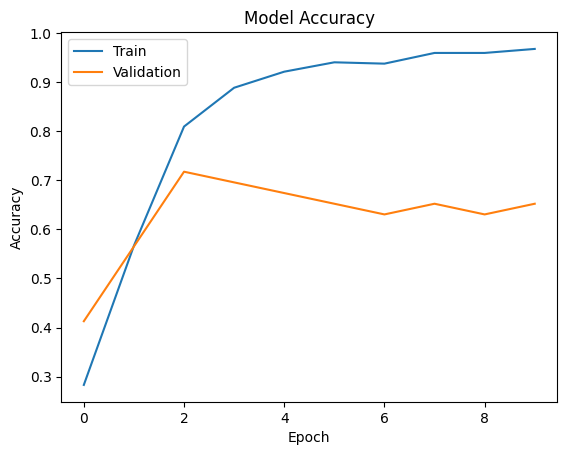

In [23]:
evaluate.get_accuracy_plot(history)

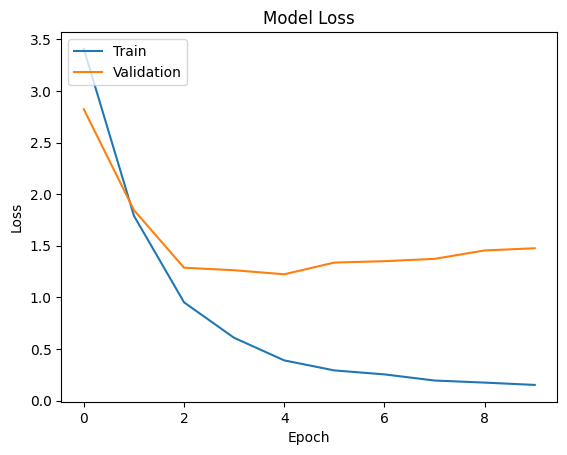

In [24]:
evaluate.get_loss_plot(history)

In [25]:
evaluate.compare_predicted_intents()

                  intent        predicted_intent
39            i_get_back              i_get_back
30          project_want              i_get_back
26              thanking                thanking
9           payment_link            payment_link
34            give_email               ask_email
8               location            payment_link
25       demo_discussion  live_session_mentoring
26              thanking                thanking
39            i_get_back     refund_process_time
26              thanking                thanking
25       demo_discussion         demo_discussion
10                Paypal               ask_email
7                  MLOPS            payment_link
31           refund_info             refund_info
26              thanking                thanking
26              thanking                thanking
2           download_can              enrollment
30          project_want            project_want
24            projectpro              i_get_back
28      discount_stu

In [85]:
evaluate.get_fscore()

/home/kai/anaconda3/envs/chatbot-final/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kai/anaconda3/envs/chatbot-final/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kai/anaconda3/envs/chatbot-final/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(

,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,1.000000
2,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,1.000000
5,0.000000,0.000000,0.000000,1.000000
6,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000
10,1.000000,1.000000,1.000000,1.000000
11,1.000000,0.500000,0.666667,2.000000
12,0.500000,0.500000,0.500000,2.000000
13,0.000000,0.000000,0.000000,1.000000


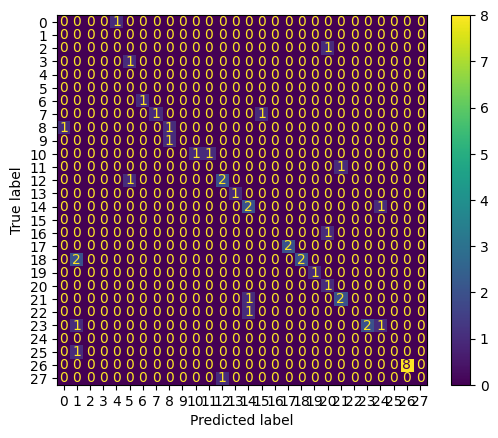

In [67]:
evaluate.get_confusion_matrix()

## Run chatbot

In [26]:
class Predict:
    '''Class for model inference.'''

    def __init__(self, model, intents, intent_data, utt):
        '''Args:
            model (str): Variable name for model path.
            intents (:obj:`list`): Ordered list of intent labels.
            intent_data (:obj:, `dict`): Dictionary containing intents as keys
            and and dictionaries of queries and responses as values.
            utt (str): Utterance to be used to predict intent.
        '''

        self.intent_data = intent_data

        self.intents = intents

        self.model = model

        # instantiate Utt object
        parsed_utt = Utt(utt, query=True)
        
        # preprocess utterance
        self.utt = parsed_utt.parse_utt()

        if self.utt:
            self.predicted_intent = self._predict_intent()

            if not self.predicted_intent:
                self.response = "Sorry, I didn't understand that. Please can you rephrase your message."
            else:
                self.response = self._get_response()
        else:
            self.response = "Sorry, I didn't understand that. Please can you rephrase your message."

    def _predict_intent(self):
        '''Given utterance, predicts intent label.'''

        query = np.array([self.utt], dtype=object)
        predict = self.model.predict(query, batch_size=32, verbose=0)
        predict_logit = predict.argmax(axis=1)
        predicted_label = self.intents[predict_logit[0]]
        if predicted_label:
            return predicted_label
        return None

    def _get_response(self):
        '''Given label, generates random response from list of available responses.'''

        response_list = self.intent_data[self.predicted_intent]['2']
        return random.choice(response_list)

In [ ]:
bot_name = "Anjali"
print("How may we help you? (type 'quit' to exit)")
while True:
    sentence = input("You: ")
    if sentence == "quit":
        break

    predict = Predict(model, intents, intent_data, sentence)
    print(f"{bot_name}: {predict.response}")

How may we help you? (type 'quit' to exit)


You:  hello


Anjali: Hi


You:  what projects do you have available?


Anjali: For accessing our services you need to enroll with us
